<a href="https://colab.research.google.com/github/kumar-sam/Job-Description-classification-BERT/blob/master/embedding_and_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [2]:
#importing the library
import re
import nltk
import numpy as np
import pandas as pd
from nltk import word_tokenize
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

Using TensorFlow backend.


In [3]:
df = pd.read_excel("/content/dataset_jd.xlsx")
df.head(2)

,JD Type,TITLE,JD
0,T,Software Developer,"Minimum Required Skills:C/C#/C++, Java/J2EE, G..."
1,T,Mechanical Engineer,Interested please share resumes ASAP. Call 301...


In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub(' ', text)


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
stop_words = stopwords.words('english')

In [7]:
df['JD'] =df['JD'].apply(remove_tags)

In [8]:
def preprocessJob(job_desc):
    """
        processess the document text by removing punct, digits,
        replaces phrase skill words with underscore, removes stop_words
        """
    global stop_words

    job_desc = job_desc.lower()
    #replacing html based space(&nbsp)
    job_desc = job_desc.replace('&nbsp', ' ')

    #dealing with unicode char
    job_desc = job_desc.replace(u'\xa0', u' ')
    job_desc = re.sub(r'[^\x00-\x7F]',' ', job_desc)

    # Removes non-alphabetic characters excluding _
    job_desc= re.sub('[^.A-Za-z]', ' ', job_desc)
    #replacing multiple space with single space
    job_desc = re.sub('\s+', ' ', job_desc)

    tokens = word_tokenize(str(job_desc))
    result = [token for token in tokens if token not in stop_words]
    result = " ".join(result)
    return result


In [9]:
df['JD'] =df['JD'].apply(preprocessJob)

In [10]:
for jd in df.JD.values[0:5]:
  print(jd)

minimum required skills c c c java j ee gui development software development life cycle ts sci clearance full scope polygraphif software developer ts sci full scope polygraph read high end engineering services company central focus protecting propelling nations cyber resources . based washington d.c metro area specialize big data analytics batch streaming cloud computing infrastructure multi int visualization enterprise architectures . also support operational missions source financial cnd serve product owners open source research initiatives.what need positionat least ten years software development engineering c c c comparable languages implementing software life cycle management build guis custom applicationswhat great base salary k doe amazing benefits edu assistance k ptoso software developer full scope polygraph please apply today applicants must authorized work u.s.security clearance needed therefore us citizens considered.please apply directly clicking click apply word resume lo

In [11]:
df.head(3)

,JD Type,TITLE,JD
0,T,Software Developer,minimum required skills c c c java j ee gui de...
1,T,Mechanical Engineer,interested please share resumes asap . call fa...
2,T,Product Engineer,responsibilities designing developing products...


In [12]:
df = df[['JD','JD Type']]

In [13]:
df.rename(columns={"JD": "text", "JD Type": "label"}, inplace=True, errors="raise")

In [14]:
df.head(3)

,text,label
0,minimum required skills c c c java j ee gui de...,T
1,interested please share resumes asap . call fa...,T
2,responsibilities designing developing products...,T


In [15]:
def trim_label(label):
  return label.strip()

In [16]:
df['label'] = df['label'].apply(trim_label)

In [17]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df['label'] = LE.fit_transform(df['label'])
df.head()

,text,label
0,minimum required skills c c c java j ee gui de...,1
1,interested please share resumes asap . call fa...,1
2,responsibilities designing developing products...,1
3,serves liaison internal external business comm...,0
4,company descriptionwinning edge solutions tech...,1


In [18]:
df.shape

(3608, 2)

In [19]:
df.label.value_counts()

1    1963
0    1645
Name: label, dtype: int64

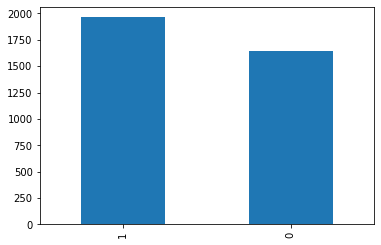

In [20]:
df.label.value_counts().plot(kind='bar')

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=35)


In [22]:
X_train.reset_index(drop = True, inplace=True)
X_train.head()

0    minimum required skills photoshop front end de...
1    years business group one trading leading speci...
2    entry help desk coordinator skills years exper...
3    minimum required skills rest apis agile java u...
4    responsibilities kforce client searching help ...
Name: text, dtype: object

In [23]:
X_test.reset_index(drop = True, inplace=True)
X_test.head()

0    minimum required skills linux devops chef pupp...
1    skills mandatory preferabletechnical skills ye...
2    title .net developer location boca raton fl du...
3    location rocklin caposition senior developer t...
4    duties migrating sql server data warehouse aws...
Name: text, dtype: object

In [24]:
y_train.reset_index(drop = True, inplace=True)
y_train.head()

0    1
1    0
2    0
3    1
4    1
Name: label, dtype: int64

In [25]:
y_test.reset_index(drop = True, inplace=True)
y_test.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

### creating word embedding

In [26]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [27]:
df['text'].values

array(['minimum required skills c c c java j ee gui development software development life cycle ts sci clearance full scope polygraphif software developer ts sci full scope polygraph read high end engineering services company central focus protecting propelling nations cyber resources . based washington d.c metro area specialize big data analytics batch streaming cloud computing infrastructure multi int visualization enterprise architectures . also support operational missions source financial cnd serve product owners open source research initiatives.what need positionat least ten years software development engineering c c c comparable languages implementing software life cycle management build guis custom applicationswhat great base salary k doe amazing benefits edu assistance k ptoso software developer full scope polygraph please apply today applicants must authorized work u.s.security clearance needed therefore us citizens considered.please apply directly clicking click apply word r

In [28]:
tokenizer_obj = Tokenizer()
total_reviews = df['text'].values

tokenizer_obj.fit_on_texts(total_reviews)

#pad sequences
max_length = max(len(s.split()) for s in total_reviews)

#define vocabulory
vocab_size = len(tokenizer_obj.word_index) + 1

X_train_tokens = tokenizer_obj.texts_to_sequences(X_train)
X_test_tokens = tokenizer_obj.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_tokens, maxlen =max_length, padding= 'post')
X_test_pad = pad_sequences(X_test_tokens, maxlen = max_length, padding= 'post')

In [29]:
X_train_pad

array([[  78,    6,    4, ...,    0,    0,    0],
       [   8,    5,  311, ...,    0,    0,    0],
       [ 815,  148,  687, ...,    0,    0,    0],
       ...,
       [  22,   81,   29, ...,    0,    0,    0],
       [  78,    6,    4, ...,    0,    0,    0],
       [1193,   40,   22, ...,    0,    0,    0]], dtype=int32)

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

In [31]:
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length= max_length ))
model.add( GRU(units =32, dropout= 0.2, recurrent_dropout= 0.2))
model.add( Dense(128, activation= 'relu'))
model.add( Dense(128, activation= 'relu'))
model.add( Dense(64, activation= 'relu'))
model.add( Dense(64, activation= 'relu'))
model.add( Dense(1, activation= 'sigmoid'))

model.compile( loss= 'binary_crossentropy', optimizer ='adam', metrics =['accuracy'])

In [ ]:
model.fit(X_train_pad, y_train, batch_size=10, epochs =250, validation_data=(X_test_pad, y_test), verbose=2)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2886 samples, validate on 722 samples
Epoch 1/250
 - 205s - loss: 0.6910 - accuracy: 0.5440 - val_loss: 0.6908 - val_accuracy: 0.5360
Epoch 2/250
 - 204s - loss: 0.6897 - accuracy: 0.5461 - val_loss: 0.6909 - val_accuracy: 0.5360
Epoch 3/250
 - 204s - loss: 0.6893 - accuracy: 0.5461 - val_loss: 0.6906 - val_accuracy: 0.5360
Epoch 4/250
 - 202s - loss: 0.6894 - accuracy: 0.5461 - val_loss: 0.6907 - val_accuracy: 0.5360
Epoch 5/250
 - 201s - loss: 0.6893 - accuracy: 0.5461 - val_loss: 0.6907 - val_accuracy: 0.5360
Epoch 6/250
 - 201s - loss: 0.6896 - accuracy: 0.5461 - val_loss: 0.6907 - val_accuracy: 0.5360
Epoch 7/250
 - 201s - loss: 0.6893 - accuracy: 0.5461 - val_loss: 0.6906 - val_accuracy: 0.5360
Epoch 8/250
 - 201s - loss: 0.6892 - accuracy: 0.5461 - val_loss: 0.6912 - val_accuracy: 0.5360
Epoch 9/250
 - 201s - loss: 0.6895 - accuracy: 0.5461 - val_loss: 0.6909 - val_accuracy: 0.5360
Epoch 10/250
 - 202s - loss: 0.6890 - accuracy: 0.5461 - val_loss: 0.6906 - val_accuracy:

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1096, 100)         2602300   
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12768     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                